In [43]:
import numpy as np
import matplotlib.pyplot as plt
import odl


### 2D Shepp Logan Phantom test

(-0.5, 255.5, 255.5, -0.5)

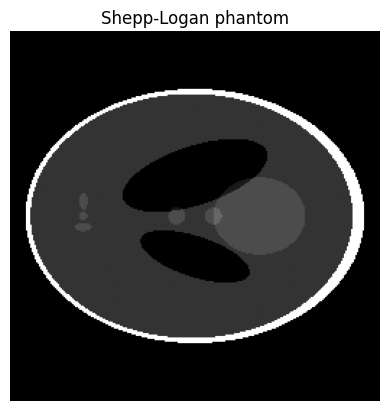

In [44]:
space = odl.uniform_discr(
    min_pt=[-1, -1],
    max_pt=[1, 1],
    shape=[256, 256],
    dtype='float32'
)

phantom = odl.phantom.shepp_logan(space, modified=True)
plt.imshow(phantom, cmap='gray')
plt.title("Shepp-Logan phantom")
plt.axis("off")


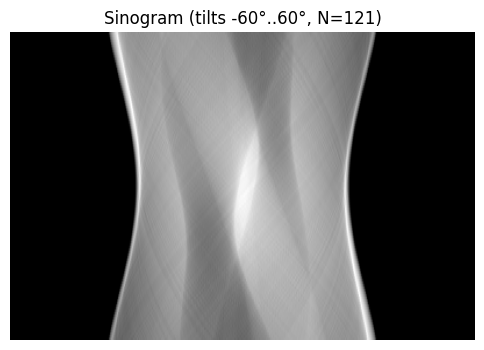

In [45]:
angular_coverage = (-60, 60)  # degrees
step = 1  # degree step

a0, a1 = np.deg2rad(angular_coverage[0]), np.deg2rad(angular_coverage[1])
n_angles = int((angular_coverage[1] - angular_coverage[0]) / step) + 1  # 121

angles = odl.uniform_partition(a0, a1, n_angles)
det = odl.uniform_partition(-1.5, 1.5, 400)
geom = odl.tomo.Parallel2dGeometry(angles, det)

A = odl.tomo.RayTransform(space, geom, impl="astra_cuda")
sino = A(phantom)

plt.figure(figsize=(6,4))
plt.imshow(sino, cmap="gray", aspect="auto")
plt.title(f"Sinogram (tilts {angular_coverage[0]}°..{angular_coverage[1]}°, N={n_angles})")
plt.axis("off")
plt.show()


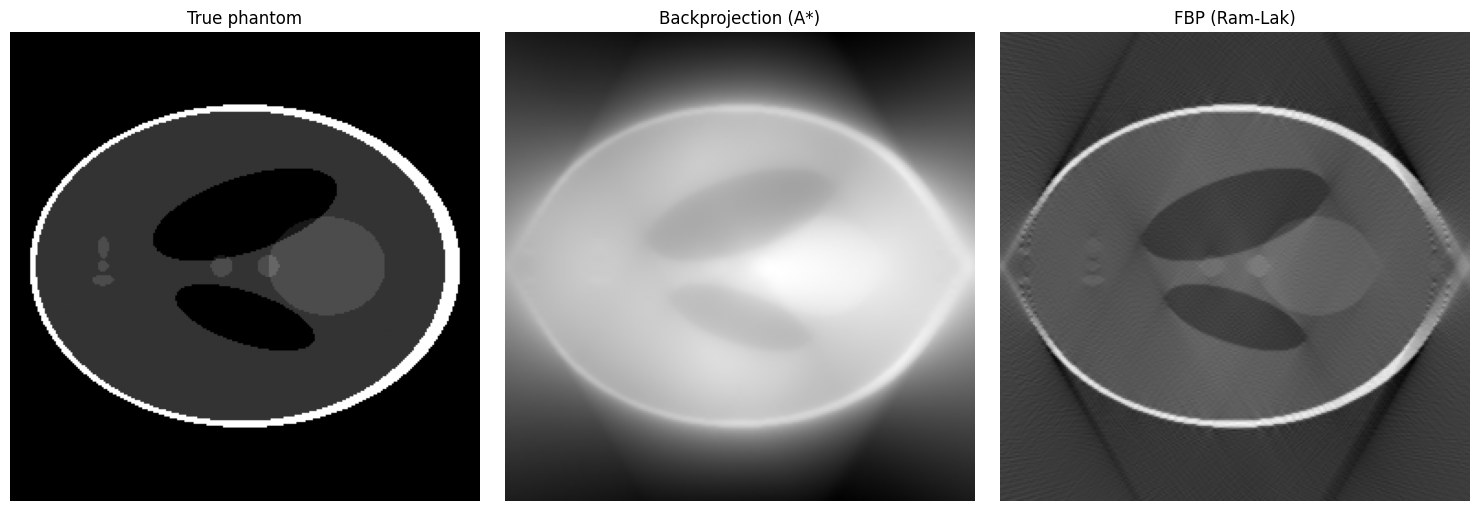

In [46]:
# Backprojection (adjoint)
bp = A.adjoint(sino)

# Filtered backprojection
# Availible filters: 'Ram-Lak', 'Shepp-Logan', 'Cosine', 'Hamming', 'Hann'
filter_used = "Ram-Lak"
fbp_op = odl.tomo.fbp_op(A, filter_type=filter_used)
fbp = fbp_op(sino)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(phantom, cmap="gray"); ax[0].set_title("True phantom"); ax[0].axis("off")
ax[1].imshow(bp, cmap="gray"); ax[1].set_title("Backprojection (A*)"); ax[1].axis("off")
ax[2].imshow(fbp, cmap="gray"); ax[2].set_title(f"FBP ({filter_used})"); ax[2].axis("off")
plt.tight_layout()
plt.show()


### Test with Poisson noise

### And Gaussian noise

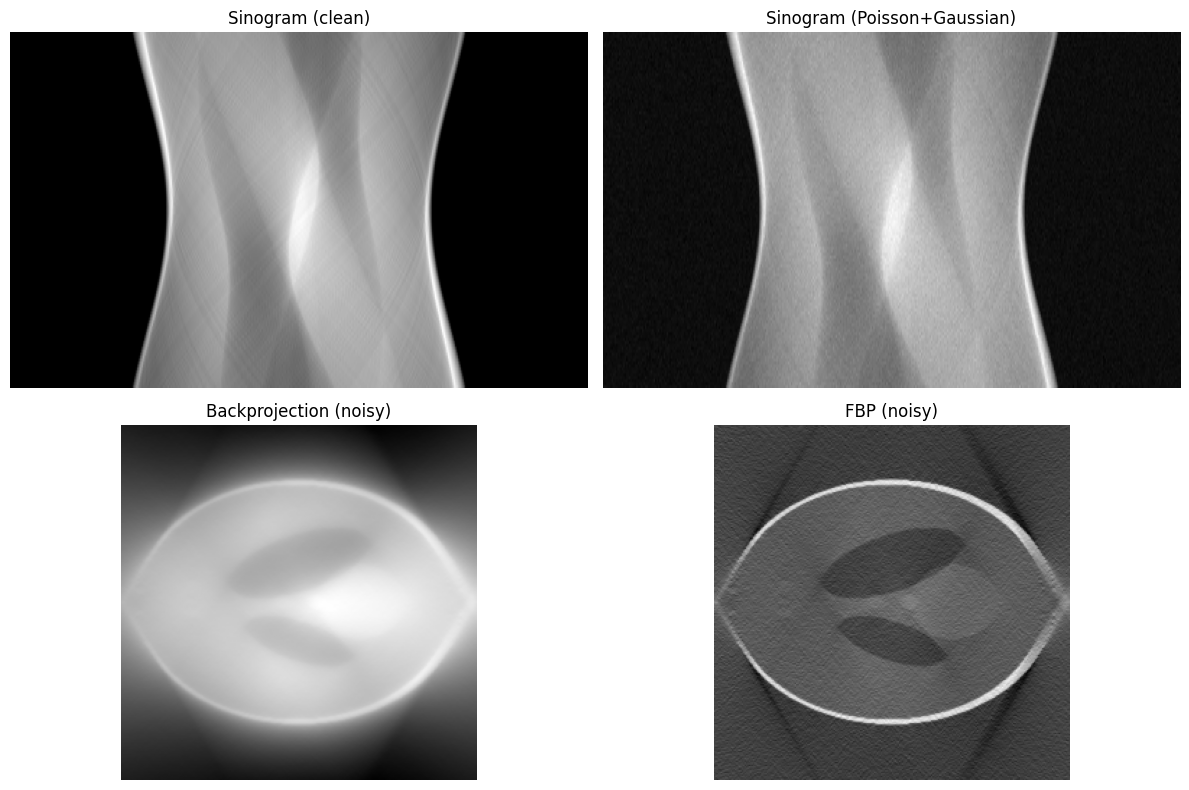

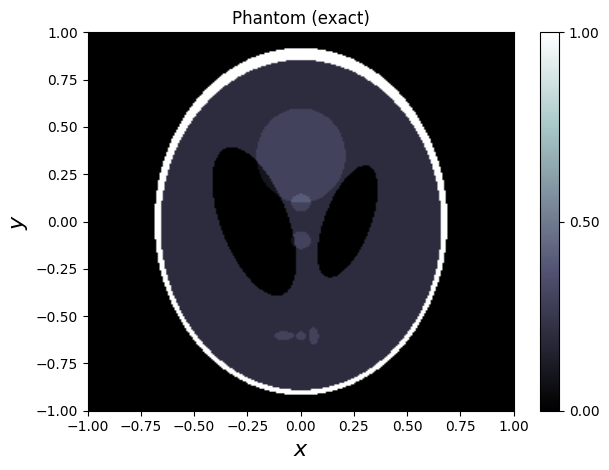

<Figure size 640x480 with 0 Axes>

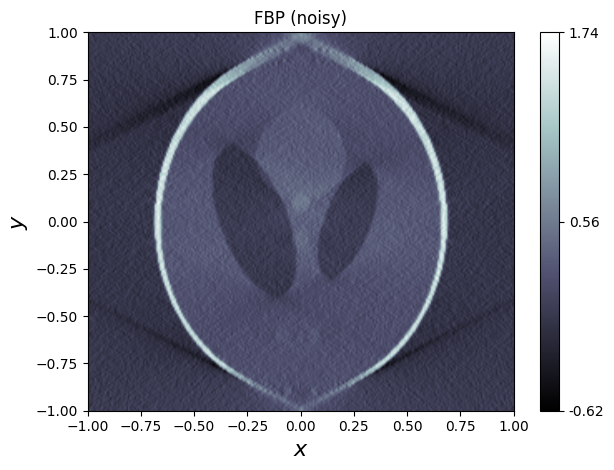

<Figure size 640x480 with 0 Axes>

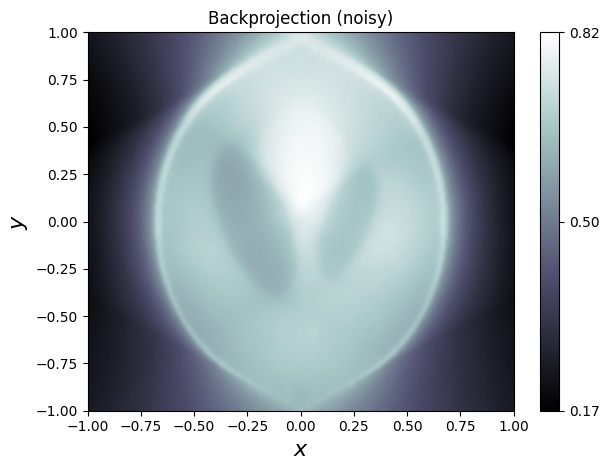

<Figure size 640x480 with 0 Axes>

In [47]:
from odl.phantom.noise import poisson_noise, white_noise

# Clean sinogram as ODL element and NumPy array
p_clean = sino.asarray()

I0 = 2e4
sigma = 3.0  # counts

# Expected counts (ODL element in A.range)
lam = A.range.element(I0 * np.exp(-p_clean))

# Poisson + optional Gaussian (both in A.range)
I = poisson_noise(lam, seed=0)
I = I + white_noise(A.range, mean=0.0, stddev=sigma, seed=1)

# Clamp in numpy (avoid log problems)
I_arr = np.maximum(I.asarray(), 1.0)

# Noisy log-sinogram (ODL element)
sino_noisy = A.range.element(-np.log(I_arr / I0))
p_noisy = sino_noisy.asarray()

# Recon
bp_noisy  = A.adjoint(sino_noisy)
fbp_noisy = fbp_op(sino_noisy)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].imshow(sino.asarray(), cmap="gray", aspect="auto")
ax[0, 0].set_title("Sinogram (clean)")
ax[0, 0].axis("off")

ax[0, 1].imshow(sino_noisy.asarray(), cmap="gray", aspect="auto")
ax[0, 1].set_title(f"Sinogram (Poisson+Gaussian)")
ax[0, 1].axis("off")

ax[1, 0].imshow(bp_noisy.asarray(), cmap="gray")
ax[1, 0].set_title("Backprojection (noisy)")
ax[1, 0].axis("off")

ax[1, 1].imshow(fbp_noisy.asarray(), cmap="gray")
ax[1, 1].set_title("FBP (noisy)")
ax[1, 1].axis("off")

plt.tight_layout()
plt.show()


phantom.show(title="Phantom (exact)")
fbp_noisy.show(title="FBP (noisy)")
bp_noisy.show(title="Backprojection (noisy)")
plt.show()



### DG representation

In [48]:
def make_structured_quad_mesh(domain, Kx, Ky):
    """
    Structured quad mesh on a rectangle domain.
    
    domain = (xmin, xmax, ymin, ymax)
    returns dict with x_edges, y_edges, elem_bounds
    """
    xmin, xmax, ymin, ymax = domain
    x_edges = np.linspace(xmin, xmax, Kx + 1)
    y_edges = np.linspace(ymin, ymax, Ky + 1)

    # elem_bounds[ey, ex] = (x0, x1, y0, y1)
    elem_bounds = np.zeros((Ky, Kx, 4), dtype=float)
    for ey in range(Ky):
        for ex in range(Kx):
            x0, x1 = x_edges[ex], x_edges[ex + 1]
            y0, y1 = y_edges[ey], y_edges[ey + 1]
            elem_bounds[ey, ex, :] = (x0, x1, y0, y1)

    return {
        "domain": domain,
        "Kx": Kx, "Ky": Ky,
        "x_edges": x_edges,
        "y_edges": y_edges,
        "elem_bounds": elem_bounds
    }

#-------------------------------------------------------#
from numpy.polynomial.legendre import leggauss, Legendre

def gl_nodes(N):
    x, w = leggauss(N + 1)
    return x, w

def gll_nodes(N):
    if N < 1:
        raise ValueError("GLL needs N>=1.")
    if N == 1:
        x = np.array([-1.0, 1.0])
        w = np.array([1.0, 1.0])
        return x, w

    PN = Legendre.basis(N)
    x_int = PN.deriv().roots()
    x = np.concatenate(([-1.0], x_int, [1.0]))
    w = 2.0 / (N * (N + 1) * (PN(x) ** 2))
    return x, w

def reference_nodes(N, kind):
    kind = kind.upper()
    if kind == "GL":
        return gl_nodes(N)
    if kind == "GLL":
        return gll_nodes(N)
    raise ValueError("kind must be 'GL' or 'GLL'")



In [49]:
def bilinear_sample(img, xq, yq, xgrid, ygrid):
    """
    img shape (Ny, Nx); xgrid (Nx,), ygrid (Ny,)
    xq,yq arrays same shape -> sampled values same shape
    """
    Ny, Nx = img.shape
    dx = (xgrid[-1] - xgrid[0]) / (Nx - 1)
    dy = (ygrid[-1] - ygrid[0]) / (Ny - 1)

    ix = (xq - xgrid[0]) / dx
    iy = (yq - ygrid[0]) / dy

    i0 = np.floor(ix).astype(int)
    j0 = np.floor(iy).astype(int)

    i0 = np.clip(i0, 0, Nx - 2)
    j0 = np.clip(j0, 0, Ny - 2)

    tx = ix - i0
    ty = iy - j0

    f00 = img[j0,     i0]
    f10 = img[j0,     i0 + 1]
    f01 = img[j0 + 1, i0]
    f11 = img[j0 + 1, i0 + 1]

    return (1-tx)*(1-ty)*f00 + tx*(1-ty)*f10 + (1-tx)*ty*f01 + tx*ty*f11


In [50]:
def interpolate_image_to_dg_nodes(
    img, xgrid, ygrid,
    mesh, N,
    node_x="GL",
    node_y="GLL",
    return_coords=True,
    dtype=np.float32
):
    """
    Returns nodal coefficients U_nodal[ey,ex,i,j] on each element.
    Also returns reference nodes (r,s) and optionally physical node coords.
    """
    Ky, Kx = mesh["Ky"], mesh["Kx"]
    elem_bounds = mesh["elem_bounds"]

    r, _ = reference_nodes(N, node_x)   # x-direction nodes on [-1,1]
    s, _ = reference_nodes(N, node_y)   # y-direction nodes on [-1,1]

    U_nodal = np.zeros((Ky, Kx, N+1, N+1), dtype=dtype)

    if return_coords:
        X_nodes = np.zeros((Ky, Kx, N+1, N+1), dtype=np.float64)
        Y_nodes = np.zeros((Ky, Kx, N+1, N+1), dtype=np.float64)

    for ey in range(Ky):
        for ex in range(Kx):
            x0, x1, y0, y1 = elem_bounds[ey, ex]

            # affine map from ref [-1,1] to physical element
            x_phys = 0.5*(x0+x1) + 0.5*(x1-x0)*r
            y_phys = 0.5*(y0+y1) + 0.5*(y1-y0)*s

            X, Y = np.meshgrid(x_phys, y_phys, indexing="ij")  # (N+1,N+1)

            Ue = bilinear_sample(img, X, Y, xgrid, ygrid).astype(dtype)
            U_nodal[ey, ex, :, :] = Ue

            if return_coords:
                X_nodes[ey, ex, :, :] = X
                Y_nodes[ey, ex, :, :] = Y

    out = {
        "U_nodal": U_nodal,
        "r": r, "s": s,
        "node_x": node_x.upper(),
        "node_y": node_y.upper(),
        "N": N,
        "mesh": mesh
    }
    if return_coords:
        out["X_nodes"] = X_nodes
        out["Y_nodes"] = Y_nodes
    return out


In [51]:
# Suppose u is your reconstructed image as ODL element
img = bp_noisy.asarray()
Ny, Nx = img.shape

# domain consistent with your ODL space (adjust if different)
domain = (-1.0, 1.0, -1.0, 1.0)
xgrid = np.linspace(domain[0], domain[1], Nx)
ygrid = np.linspace(domain[2], domain[3], Ny)
Kx=32
Ky=32
mesh = make_structured_quad_mesh(domain, Kx=Kx, Ky=Ky)
px = Nx // Kx
py = Ny // Ky
N = int(min(px, py) - 1)           # at most one less than points per element
N = max(1, min(N, 7))              # clamp to [1,7] as a safe start

dg_data = interpolate_image_to_dg_nodes(img, xgrid, ygrid, mesh, N=N, node_x="GL", node_y="GLL")

U_nodal = dg_data["U_nodal"]
print(U_nodal.shape)  # (Ky,Kx,N+1,N+1)


(32, 32, 8, 8)


In [52]:
import numpy as np

Ky, Kx, Np, _ = U_nodal.shape
N = Np - 1

# pick a random element and node
ey = np.random.randint(Ky)
ex = np.random.randint(Kx)
i  = np.random.randint(Np)
j  = np.random.randint(Np)

# node coordinates
X = dg_data["X_nodes"][ey, ex, i, j]
Y = dg_data["Y_nodes"][ey, ex, i, j]

# resample original image at that point (same bilinear sampler!)
val = bilinear_sample(img, np.array([[X]]), np.array([[Y]]), xgrid, ygrid)[0,0]

print("DG nodal value :", U_nodal[ey, ex, i, j])
print("Resampled img  :", val)
print("abs error      :", abs(U_nodal[ey, ex, i, j] - val))


DG nodal value : 0.700162
Resampled img  : 0.700161633172
abs error      : 2.70389033385e-09


In [53]:
import numpy as np
from numpy.polynomial.legendre import legvander

def make_vandermonde_1d_legendre(nodes, N):
    """
    Vandermonde matrix V with V[i,j] = P_j(nodes[i]), j=0..N
    using Legendre polynomials P_j on [-1,1].
    """
    nodes = np.asarray(nodes, dtype=float)
    V = legvander(nodes, N)  # shape (N+1, N+1) if len(nodes)=N+1
    return V


In [54]:
def dg_nodal_to_modal_all(U_nodal, r_nodes, s_nodes):
    """
    Convert DG nodal values to modal coefficients elementwise.

    U_nodal: (Ky, Kx, N+1, N+1) with i=x-index, j=y-index.
    Returns:
      U_modal: same shape
      Vr, Vs: 1D Vandermonde matrices
    """
    Ky, Kx, Np, _ = U_nodal.shape
    N = Np - 1

    Vr = make_vandermonde_1d_legendre(r_nodes, N)
    Vs = make_vandermonde_1d_legendre(s_nodes, N)

    U_modal = np.zeros_like(U_nodal, dtype=np.float64)

    for ey in range(Ky):
        for ex in range(Kx):
            Ue = U_nodal[ey, ex].astype(np.float64)

            # A = Vr^{-1} Ue
            A = np.linalg.solve(Vr, Ue)

            # Uhat^T = Vs^{-1} A^T  => Uhat = (Vs^{-1} A^T)^T
            Uhat = np.linalg.solve(Vs, A.T).T

            U_modal[ey, ex] = Uhat

    return U_modal, Vr, Vs

def dg_modal_to_nodal_all(U_modal, Vr, Vs):
    """
    Convert modal coefficients back to nodal values elementwise:
      U = Vr * Uhat * Vs^T
    """
    Ky, Kx, _, _ = U_modal.shape
    U_nodal_rec = np.zeros_like(U_modal, dtype=np.float64)

    for ey in range(Ky):
        for ex in range(Kx):
            Uhat = U_modal[ey, ex]
            U_nodal_rec[ey, ex] = Vr @ Uhat @ Vs.T

    return U_nodal_rec



In [55]:
def eval_modal_dg_on_grid(U_modal, mesh, xgrid, ygrid):
    """
    Evaluate modal DG field on the Cartesian grid (xgrid,ygrid).
    U_modal shape (Ky,Kx,N+1,N+1) uses Legendre modes.
    """
    Ky, Kx, Np, _ = U_modal.shape
    N = Np - 1
    x_edges, y_edges = mesh["x_edges"], mesh["y_edges"]

    img_out = np.zeros((len(ygrid), len(xgrid)), dtype=np.float64)

    for ey in range(Ky):
        y0, y1 = y_edges[ey], y_edges[ey+1]
        jy = np.where((ygrid >= y0) & ((ygrid < y1) if ey < Ky-1 else (ygrid <= y1)))[0]
        if jy.size == 0:
            continue
        s = 2*(ygrid[jy] - y0)/(y1 - y0) - 1
        Ps = legvander(s, N)  # (My, N+1)
        for ex in range(Kx):
            x0, x1 = x_edges[ex], x_edges[ex+1]
            ix = np.where((xgrid >= x0) & ((xgrid < x1) if ex < Kx-1 else (xgrid <= x1)))[0]
            if ix.size == 0:
                continue
            r = 2*(xgrid[ix] - x0)/(x1 - x0) - 1
            Pr = legvander(r, N)  # (Mx, N+1)

            Uhat = U_modal[ey, ex]
            block = Pr @ Uhat @ Ps.T      # (Mx, My)
            img_out[np.ix_(jy, ix)] = block.T  # (My, Mx) into (y,x)

    return img_out


round-trip nodal error: 2.37590862288e-16
rel L2 error: 0.0012676638842
max abs error: 0.00626398353795


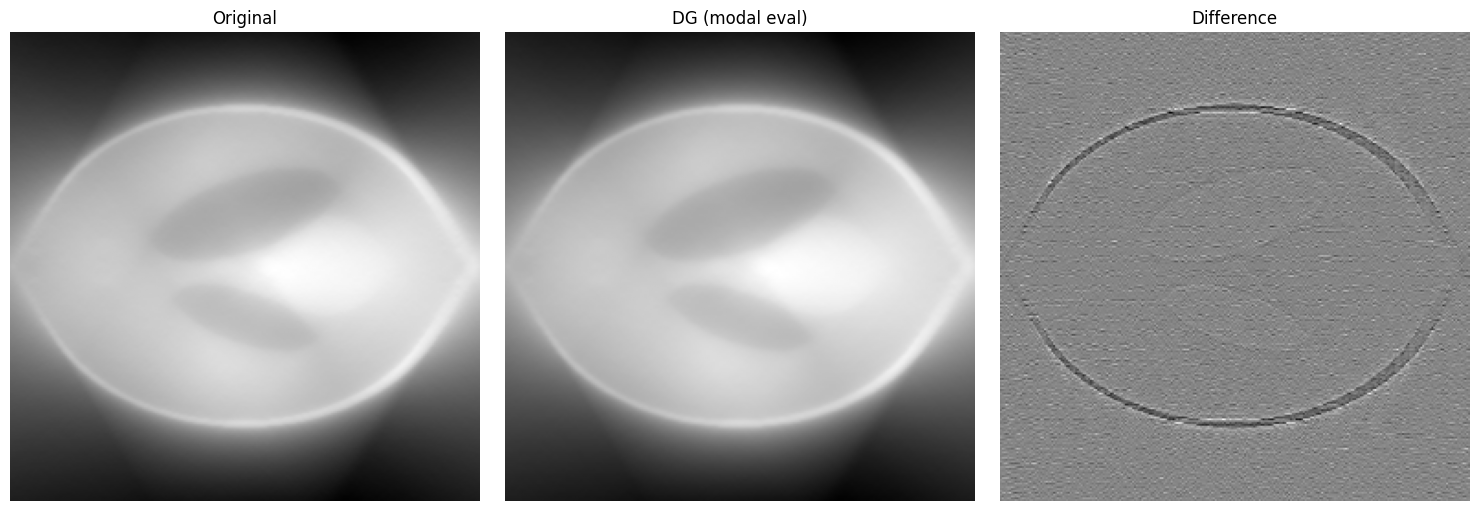

In [56]:
U_modal, Vr, Vs = dg_nodal_to_modal_all(U_nodal, dg_data["r"], dg_data["s"])
# Check by convberting back if Vandermonde matrices are correct
U_nodal_rec = dg_modal_to_nodal_all(U_modal, Vr, Vs)

rt = np.linalg.norm(U_nodal_rec - U_nodal) / np.linalg.norm(U_nodal)
print("round-trip nodal error:", rt)


img_dg = eval_modal_dg_on_grid(U_modal, mesh, xgrid, ygrid)

import matplotlib.pyplot as plt
diff = img_dg - img

print("rel L2 error:", np.linalg.norm(diff) / np.linalg.norm(img))
print("max abs error:", np.max(np.abs(diff)))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(img_dg, cmap="gray"); ax[1].set_title("DG (modal eval)"); ax[1].axis("off")
ax[2].imshow(diff, cmap="gray"); ax[2].set_title("Difference"); ax[2].axis("off")
plt.tight_layout(); plt.show()

